In [1]:
!pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 KB 5.2 MB/s eta 0:00:00


# Load libraries

In [2]:
from feature_engine.selection import RecursiveFeatureElimination
from feature_engine.creation import RelativeFeatures, MathFeatures

In [3]:
# Data manipulation and  viz
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

import gc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Feature importance with modelling
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.metrics import log_loss, cohen_kappa_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedStratifiedKFold,StratifiedKFold, RepeatedKFold
from scipy.stats import boxcox, median_abs_deviation
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFECV, SelectKBest
from sklearn.decomposition import PCA

import shap 
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
from sklearn.linear_model import Ridge, LinearRegression, HuberRegressor, Lasso,LassoCV,SGDRegressor
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor,RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR

In [4]:
#suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
target = "Strength" #Target column that we will be predicting, this is here for quick reference 

# Different scaling options
SCALING = False
SCALER = QuantileTransformer(output_distribution = "normal") #RobustScaler()

TEST_ON_GENERATED_ONLY = True
ADD_DATA= True
EPOCHS= 1000

FEATURE_ENGINE = False
USE_SYM  = False

NUM_FOLDS =5
NUM_SPLITS = 3

RFECV1 = True
RFE_STEP = 0.01

name = 'Gradient' #LinearRegression rf #ET catboost lightgbm xgboost Gradient, Ridge, SVR ----for LR turn off 'Test_on_Generated'

In [6]:
# Notebook settings
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

## 💾 Load Data 💾
Data taken from TPS May 2022 competition 

In [7]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv", index_col = 0)
df_test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv", index_col = 0)
sub = pd.read_csv("/kaggle/input/playground-series-s3e9/sample_submission.csv",index_col = 0)
df_train

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
...,...,...,...,...,...,...,...,...,...
5402,446.0,24.0,79.0,162.0,11.6,967.0,712.0,3,15.42
5403,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,49.20
5404,295.8,0.0,0.0,185.7,0.0,1076.2,759.3,28,39.30


In [8]:
if ADD_DATA:
    add_data = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')
    
    print("length of additional data", len(add_data))
    print("length of original data", len(df_train))
    df_train['is_generated'] = 1
    df_test['is_generated'] = 1
    add_data['is_generated'] = 0
    add_data.columns =df_train.columns

    df_train = pd.concat([df_train, add_data],axis=0, ignore_index=True)
df_train

length of additional data 1030
length of original data 5407


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


In [9]:
if USE_SYM:
    sym_cols_trn = pd.read_csv("/kaggle/input/pse3e9-2-feature-creation-symbolic-transform/Symbolic_Feats_trn_12.01.csv", index_col = 0).set_index(df_train.index)
    df_train  = pd.concat([df_train,sym_cols_trn], axis =1,ignore_index = True) 
    df_test  = pd.concat([df_test,sym_cols_trn], axis =1,ignore_index = True) 
df_test

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,is_generated
id,,,,,,,,,
5407,166.1,75.4,163.8,173.8,4.6,1007.2,746.6,56,1
5408,304.0,0.0,0.0,190.0,0.0,998.0,801.0,7,1
5409,225.0,0.0,0.0,185.0,0.0,1113.0,833.0,28,1
5410,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100,1
5411,144.0,15.0,195.0,176.0,6.0,1021.0,709.0,28,1
...,...,...,...,...,...,...,...,...,...
9007,140.0,129.0,100.0,200.0,7.0,864.0,753.0,28,1
9008,281.0,0.0,0.0,186.0,0.0,1104.0,774.0,28,1
9009,289.0,133.0,0.0,194.0,7.0,924.0,760.0,28,1


## Helper Functions

In [10]:
def base_model(X_trn,y_trn,X_tst,y_tst, name,model_in, X_in, test_in, print_scores = True):
    
    if name in ["lightgbm"]:
        model_in.fit(X_trn,y_trn,
              eval_set=[(X_tst,y_tst)],
              callbacks= [lgb.log_evaluation(-1), lgb.early_stopping(30)])
        
    elif name in ["xgboost"]:
        model_in.fit(X_trn,y_trn,
                     eval_set=[(X_tst,y_tst)],
                  verbose= 0
                 )
    elif name in ["catboost"]:
        model_in.fit(X_trn,y_trn,
                  eval_set=[(X_tst,y_tst)],
                  early_stopping_rounds=30,
                  verbose= 0
                 )          
    else:
        model_in.fit(X_trn,y_trn)

    val_preds = model_in.predict(X_tst)
    trn_preds = model_in.predict(X_in)
    test_preds = model_in.predict(test_in)
    
    score_trn =mean_squared_error(y, trn_preds)**0.5
    score_val = mean_squared_error(y_tst, val_preds )**0.5
    
    if print_scores:
        print("\nTrn Score:",score_trn)
        print("Val Score:",score_val)
        #print("Val logloss", log_loss(y,trn_preds_base))
    
    return test_preds, trn_preds, val_preds, score_trn, score_val, model_in

In [11]:
def mean_squared_error_root(y_true,y_pred):
    return  mean_squared_error(y_true,y_pred)**0.5
scorer = make_scorer(mean_squared_error_root,greater_is_better=False)
kfold = RepeatedKFold(n_splits=NUM_FOLDS, n_repeats=NUM_SPLITS, random_state=200)

# 🎯 Feature Engineering 🎯
* Here we create features and process our data, by steps that were identified in our EDA

In [12]:
df_trn = df_train.copy(deep = True)
df_tst = df_test.copy(deep = True)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


### Duplicates
Drop duplicates (we include target column) 

In [13]:
print("Duplicated rows:",df_trn.duplicated().sum())
print("Duplicated rows, less target:",df_trn.drop(target,axis =1).duplicated().sum())
print("Length of train:",len(df_trn))
print(f"Percentage as duplicates (less target): {df_trn.drop(target,axis =1).duplicated().sum()/len(df_trn)*100:.2f}%" )

df_trn.drop_duplicates(inplace = True,ignore_index  = True)
#df_tst.drop_duplicates(inplace = True,ignore_index  = True)
print(df_trn.duplicated().sum())

Duplicated rows: 25
Duplicated rows, less target: 2439
Length of train: 6437
Percentage as duplicates (less target): 37.89%
0


# Feature Engine 

In [14]:
int_cols = df_trn.dtypes[(df_trn.dtypes =="int64") & (df_trn.dtypes.index != target) ].index
float_cols = df_trn.dtypes[(df_trn.dtypes =="float64") & (df_trn.dtypes.index != target)].index
float_cols

Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent'],
      dtype='object')

In [15]:
if FEATURE_ENGINE: 
    
    functions = [
        'add', 
        'mul','sub' #, 'pow',   #'mod', 'div', 'truediv','floordiv'
    ]
    FE = RelativeFeatures(variables  = list(float_cols), reference=list(float_cols)  ,func = functions, drop_original=False, missing_values= "ignore")
    df_trn= FE.fit_transform(X = df_trn)
    df_tst= FE.fit_transform(X = df_tst)

#### Drop cols 
drop columns that subtract themselves 

In [16]:
if FEATURE_ENGINE: 
    drop_cols = []
    for i in df_test.columns:
        drop_cols.append( i+"_sub_"+i)
    df_tst.drop(drop_cols, axis =1,errors= "ignore", inplace = True)
    df_trn.drop(drop_cols, axis =1,errors= "ignore", inplace = True)
print([col for col in df_tst.columns])

['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'is_generated']


### Additional Feats

In [17]:
def Additional_Features(df_in):
    df = df_in.copy(deep = True)
    
    
    df['total'] = df['CementComponent'] + df['BlastFurnaceSlag'] + df['FlyAshComponent'] + df['WaterComponent'] + df['SuperplasticizerComponent'] + df['CoarseAggregateComponent'] + df['FineAggregateComponent']
    df['Coarse_Fine'] = df['CoarseAggregateComponent'] / df['FineAggregateComponent']
    df['Aggregate'] = df['CoarseAggregateComponent'] + df['FineAggregateComponent']
#     df['Aggregate_Cement'] = df['Aggregate'] / df['CementComponent'] # delete
    df['Slag_Cement'] = df['BlastFurnaceSlag'] / df['CementComponent']
    df['Ash_Cement'] = df['FlyAshComponent'] / df['CementComponent']
#     df['Plastic_Cement'] = df['SuperplasticizerComponent'] / df['CementComponent']
    df['Water_Cement'] = df['WaterComponent'] / df['CementComponent']
    df['Age_Water'] = df['AgeInDays'] / df['WaterComponent']
    df['Cem_pct'] = df['CementComponent'] / df['total']
    df['Blast_pct'] = df['BlastFurnaceSlag'] / df['total']
    df['Ash_pct'] = df['FlyAshComponent'] / df['total']
    df['water_pct'] = df['WaterComponent'] / df['total']
    df['plas_pct'] = df['SuperplasticizerComponent'] / df['total']
#     df['water_pct_final'] = df['water_pct'] / (1 - df['plas_pct'])  # increase the rmse
#     cols_to_drop = ['water_pct', 'plas_pct']
    df['if_Blast'] = df['BlastFurnaceSlag'] != 0
    df['if_Ash'] = df['FlyAshComponent'] != 0
    
    
    
    # feature creation with duplicates
    for col in df_test.drop("is_generated",axis =1).columns: 
        grp_target = df_trn[df_trn.drop(target,axis =1).duplicated()].groupby(col).mean()[target]
        if 0 in grp_target.index:
            bins = list(grp_target.index)+ [max(df_trn[col])+1]
        else: 
            bins = [0] + list(grp_target.index)
        
        #add cols using bins 
        df[f"{col}_grp_mean"] = pd.cut(df[col], bins=bins, labels =grp_target.values )
        df[f"{col}_grp_mean"] = df[f"{col}_grp_mean"].astype('float64').fillna(0)

    return df

df_trn = Additional_Features(df_trn)
df_tst = Additional_Features(df_tst)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated,...,if_Blast,if_Ash,CementComponent_grp_mean,BlastFurnaceSlag_grp_mean,FlyAshComponent_grp_mean,WaterComponent_grp_mean,SuperplasticizerComponent_grp_mean,CoarseAggregateComponent_grp_mean,FineAggregateComponent_grp_mean,AgeInDays_grp_mean
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1,...,False,False,39.276327,0.000000,0.000,36.387000,0.000000,36.985248,37.088376,17.649962
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1,...,True,True,38.840000,37.260000,36.955,35.975000,50.408333,44.691111,55.160000,37.397488
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1,...,True,False,29.377143,27.623226,0.000,32.085729,0.000000,37.340000,30.250000,37.397488
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1,...,True,False,34.334118,50.408333,0.000,41.083709,0.000000,40.688405,38.541071,43.053415
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1,...,True,False,38.504211,38.965000,0.000,30.644892,0.000000,38.808889,38.808889,42.285341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6407,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0,...,True,True,35.975000,33.418182,43.590,61.865000,33.856667,29.930000,35.797500,37.397488
6408,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0,...,False,True,27.150000,0.000000,45.294,31.900000,27.150000,37.360000,48.280000,37.397488
6409,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0,...,True,True,65.910000,56.480000,48.280,39.108000,44.650000,55.640000,29.440000,37.397488
6410,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0,...,True,False,19.690000,45.910000,0.000,34.505000,38.300000,34.505000,33.200385,37.397488


# Split Data

In [18]:
# drop the text column and target
X = df_trn.drop([target],axis =1)
y= df_trn[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

### Model Parameters

In [19]:
lgb_params ={'objective': 'regression',# regression_l1, huber, fair, poisson, quantile, mape, gamma, tweedie
             "metric":"rmse", 
             "boosting": "gbdt",#"dart",gbdt
#              'lambda_l1': 1.0050418664783436e-08, 
#              'lambda_l2': 9.938606206413121,
#              'num_leaves': 44,
#               'feature_fraction': 0.8247273276668773,
#               'bagging_fraction': 0.5842711778104962,
#             'bagging_freq': 6,
#              'min_data_in_leaf': 134,
#              'min_child_samples': 70,
#              'max_depth': 8,   
             'n_estimators':EPOCHS,
             'learning_rate':0.01,
            'device':'cpu'}

xgb_params = { 
    'objective' : "reg:squarederror",
    'n_estimators' : EPOCHS, 
    #'early_stopping_rounds' :30,
    'eval_metric' : "rmse",
    'learning_rate': 0.55,
    #'max_depth': 5,
    'booster' : 'gbtree'#'gbtree',dart
             }
cat_params = {'iterations':EPOCHS,
              'eval_metric' : "RMSE", 
              'learning_rate': 0.01,
              'loss_function':'RMSE'
             }
ET_params = {'max_depth':6, 'n_estimators':EPOCHS}
RF_params = { 'max_depth':8,'n_estimators':EPOCHS,
            }

GR_params = {'loss':'squared_error',
    'learning_rate':0.1,
    'n_estimators':EPOCHS,
    'subsample':1.0,
    'criterion':'friedman_mse',
    'min_samples_split':2,
    'min_samples_leaf':1,
    'min_weight_fraction_leaf':0.0,
    'max_depth':3,
    'min_impurity_decrease':0.0,
    'max_features':None,
    'alpha':0.9,
    'verbose':0,
    'max_leaf_nodes':None,
    'warm_start':False,
    'validation_fraction':0.1,
    'n_iter_no_change':None,
    'tol':0.0001,
    'ccp_alpha':0.0}

In [20]:
if name =="xgboost":
    model= xgb.XGBRegressor(**xgb_params)
elif name =="lightgbm":
    model= lgb.LGBMRegressor(**lgb_params)
elif name == "rf":
    model = RandomForestRegressor(**RF_params)
elif name == "catboost":
    model = cat.CatBoostRegressor(**cat_params)
if name == "LinearRegression":
    model = LinearRegression()
if name == "ET":
    model =ExtraTreesRegressor(**ET_params)
if name == "SVR":    
     model =SVR( kernel = "rbf",max_iter = EPOCHS+2000) #linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
if name == "Ridge":    
     model = Ridge(alpha=430,max_iter = EPOCHS)
if name == "Gradient":    
     model = GradientBoostingRegressor(**GR_params)    

In [21]:
# if name in ["LinearRegression",'Ridge', "SVR"]:
#     scaler = StandardScaler()
#     X_train_s = scaler.fit_transform(X_train)
#     X_test_s  = scaler.transform(X_test)
#     X_temp = X.copy(deep = True)
#     X_temp = scaler.transform(X_temp)
#     test_temp = scaler.transform(df_tst)
#     y_train_s = y_train.copy(deep = True)

# elif SCALING:
#     X_train_s = SCALER.fit_transform(X_train)
#     X_test_s  = SCALER.transform(X_test)
#     X_temp = X.copy(deep = True)
#     X_temp = SCALER.transform(X_temp)
#     test_temp = SCALER.transform(df_tst)
#     y_train_s = y_train.copy(deep = True)

# else:
#     #X_train_s, X_test_s , test_temp, X_temp = Scaling(X_train, X_test , df_tst, X )
#     X_test_s = X_test.copy(deep = True)
#     X_train_s = X_train.copy(deep = True)
#     X_temp = X.copy(deep = True)
#     test_temp = df_tst.copy(deep = True)
#     y_train_s = y_train.copy(deep = True)

# #Fit
# test_preds_fold, trn_preds_fold, val_preds_fold, score_train_fold, score_val_fold , model_out= base_model(X_train_s,y_train_s,X_test_s,y_test, name,model, X_temp, test_temp, True)

# Run model (initial)

In [22]:
scores = cross_val_score(model, X, y, cv=kfold, scoring= scorer)
initial_score = np.mean(scores*-1)
initial_score

11.890148856180387

In [23]:
initial_score

11.890148856180387

# Recursive Feature Elimination 

In [24]:
if RFECV1: 
    selector = RFECV(model, step=RFE_STEP, cv=kfold, scoring="neg_root_mean_squared_error",min_features_to_select= 5)
    if SCALING: 
        selector = selector.fit(X_temp, y)      
    else:
        selector = selector.fit(X, y)

In [25]:
if RFECV1: 
    NEW_COLS = [col for col in X.columns[selector.support_]]
    print("Cols to keep:\n")
    print(NEW_COLS)

Cols to keep:

['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'is_generated', 'total', 'Coarse_Fine', 'Aggregate', 'Slag_Cement', 'Ash_Cement', 'Water_Cement', 'Age_Water', 'Cem_pct', 'Blast_pct', 'Ash_pct', 'water_pct', 'plas_pct', 'CementComponent_grp_mean', 'BlastFurnaceSlag_grp_mean', 'FlyAshComponent_grp_mean', 'WaterComponent_grp_mean', 'SuperplasticizerComponent_grp_mean', 'CoarseAggregateComponent_grp_mean', 'FineAggregateComponent_grp_mean', 'AgeInDays_grp_mean']


In [26]:
if RFECV1:
    print(f"Optimal number of features: {selector.n_features_}\n") 
    print( selector.ranking_)

Optimal number of features: 29

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 1 1 1 1 1 1 1 1]


In [27]:
if RFECV1:
    Ranked_cols = pd.DataFrame(selector.ranking_, index = X.columns).sort_values(ascending = False, by= [0] )
    Ranked_cols.to_csv("Ranked_cols.csv")
    print(selector.cv_results_)

{'mean_test_score': array([-12.25717306, -12.25734727, -12.26390327, -12.24096738,
       -12.22300987, -12.21012849, -12.09337248, -11.94156008,
       -11.92286034, -11.94651194, -11.96167938, -11.96388549,
       -11.91035033, -11.90354389, -11.89432729, -11.89497592,
       -11.89305264, -11.90803687, -11.89888365, -11.92116794,
       -11.90976363, -11.89544784, -11.89395462, -11.90585823,
       -11.8887825 , -11.89112028, -11.88978289]), 'std_test_score': array([0.24362568, 0.24817726, 0.25414353, 0.24413505, 0.25424617,
       0.27507683, 0.20203083, 0.2437052 , 0.23647509, 0.21703732,
       0.22637013, 0.19889164, 0.20873849, 0.20095863, 0.21471202,
       0.21237892, 0.21911068, 0.21953101, 0.21534505, 0.19718604,
       0.21424339, 0.22184   , 0.21790816, 0.20531676, 0.20721675,
       0.2099627 , 0.20888515]), 'split0_test_score': array([-12.73306198, -12.69359907, -12.67155114, -12.71138026,
       -12.77295268, -12.74888472, -12.28761595, -12.15087441,
       -12.2299662

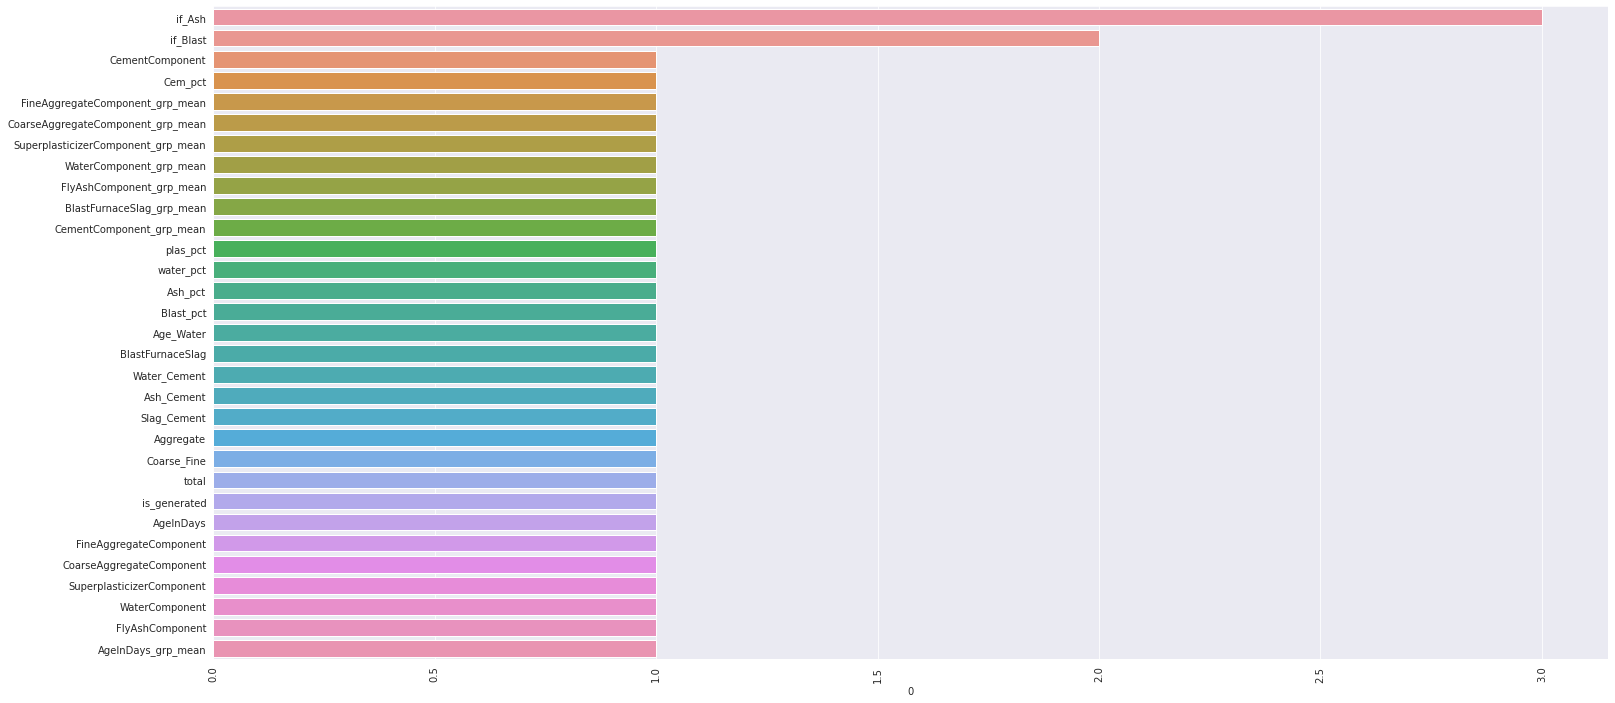

In [28]:
if RFECV1:
    plt.figure(figsize= (25,12))
    sns.barplot(x= Ranked_cols[0], y= Ranked_cols.index)
    plt.xticks(rotation = 90) 
    plt.show()

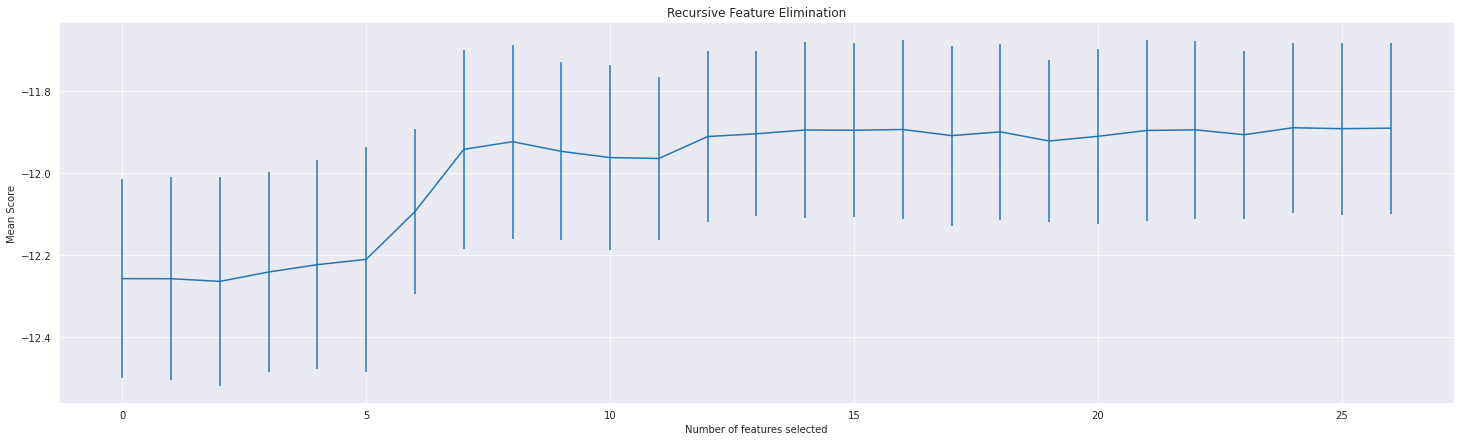

In [29]:
if RFECV1:
    try:
        n_scores = len(selector.cv_results_["mean_test_score"])
        plt.figure(figsize=(25,7))
        plt.xlabel("Number of features selected")
        plt.ylabel("Mean Score")
        plt.errorbar(
            range(0, n_scores),
            selector.cv_results_["mean_test_score"],
            yerr=selector.cv_results_["std_test_score"],
        )
        plt.title("Recursive Feature Elimination")
        plt.show()
    except:
        print("cant show")

# Resulting columns

In [30]:
print("Drop cols:")
[col for col in df_trn.drop(target,axis=1).columns if col not in NEW_COLS]

Drop cols:


['if_Blast', 'if_Ash']

In [31]:
print("Keep cols:")
print([col for col in NEW_COLS])

Keep cols:
['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'is_generated', 'total', 'Coarse_Fine', 'Aggregate', 'Slag_Cement', 'Ash_Cement', 'Water_Cement', 'Age_Water', 'Cem_pct', 'Blast_pct', 'Ash_pct', 'water_pct', 'plas_pct', 'CementComponent_grp_mean', 'BlastFurnaceSlag_grp_mean', 'FlyAshComponent_grp_mean', 'WaterComponent_grp_mean', 'SuperplasticizerComponent_grp_mean', 'CoarseAggregateComponent_grp_mean', 'FineAggregateComponent_grp_mean', 'AgeInDays_grp_mean']


# Re-test on new cols 

In [32]:
X = df_trn.drop([target],axis =1)[NEW_COLS]
df_tst = df_tst[NEW_COLS]
y= df_trn[target]

scores = cross_val_score(model, X, y, cv=kfold, scoring= scorer)
final_score = np.mean(scores*-1)
final_score

11.893761614623878

In [33]:
df_tst[NEW_COLS].to_csv("test_new_cols.csv")
df_trn[NEW_COLS+[target]].to_csv("trn_new_cols.csv")

In [34]:
print(f"Initial score:{initial_score:.4f}")
print(f"Final score:{final_score:.4f}")

Initial score:11.8901
Final score:11.8938
